In [ ]:
import cv2
import numpy as np
import pandas as pd
import scipy.stats as ss
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data

import scipy.stats as ss

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm

from PIL import Image, ImageDraw, ImageFont
import PIL

import os

import copy
import random
import time

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('./data')

Mounted at ./data


In [ ]:
PREFIX = "data/MyDrive/Colab Notebooks/Doc_recognition/Passports/"

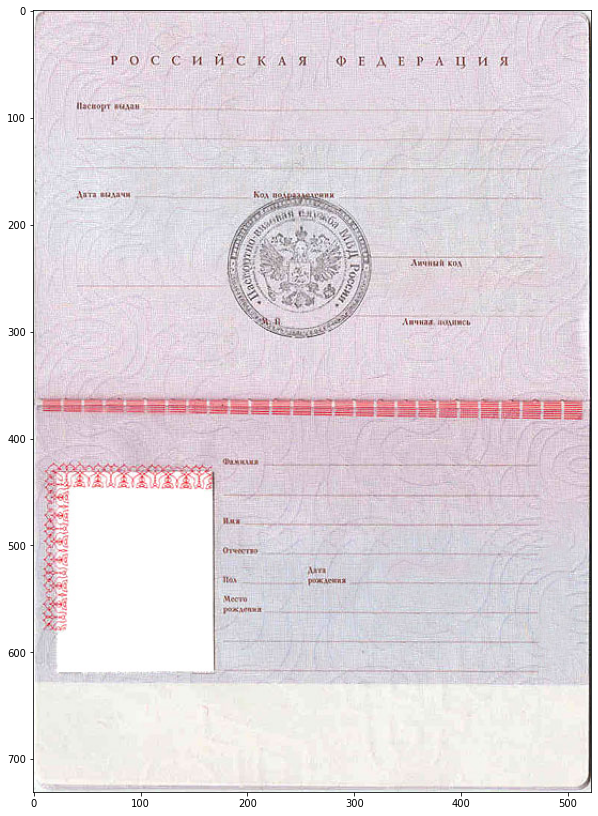

In [ ]:
passport = Image.open(PREFIX + "DatasetGeneration/passport_1.jpg")
plt.figure(figsize=(10, 16))
plt.imshow(passport)

In [ ]:
passport_font = PREFIX + 'fonts/ocrb.ttf'
f_corners = np.array([])
with open(PREFIX + "DatasetGeneration/corners.txt", "r") as file:
    f_corners = np.array(list(map(int, file.readline().split()))).reshape(-1, 2, 2)
p_corners = np.array([
    [22, 430],
    [168, 430],
    [22, 618],
    [168, 618]
])

In [ ]:
class TextField:
    passport_font = 'data/MyDrive/Colab Notebooks/Doc_recognition/Passports/fonts/ocrb.ttf'
    
    def __init__(self, corners, font_size=15, word="PASSPORT"):
        self.corners_ = corners
        self.n_str = corners.shape[0]
        self.word = word
        self.font_size = font_size
        
    def _write_short(self, img, text=None, line=0, determinized=False):
        text = text if text is not None else self.word
        w, h = img.size
        draw = ImageDraw.Draw(img)
        a, b = draw.textsize(text, font=ImageFont.truetype(passport_font, self.font_size))
        
        y_shift = np.random.choice(np.arange(max(1, b // 2))) * np.random.choice([-1/2, 1]) * (1 - determinized)
        x_shift = np.random.choice(
            np.arange(max(1, (self.corners_[line, 1, 0] - self.corners_[line, 0, 0] - a) // 2))
        ) // 3 * np.random.choice([-1, 1]) * (1 - determinized)
        
        x = (self.corners_[line, 0, 0] + self.corners_[line, 1, 0] - a) / 2 + x_shift
        y = self.corners_[line, 0, 1] - b - y_shift
        draw.text((x, y), text, font=ImageFont.truetype(passport_font, self.font_size), fill=(50, 50, 50))
        return img
    
    def write_long(self, img, determinized=False):
        draw = ImageDraw.Draw(img)
        words = list(self.word.replace('-', '- ').split())
        lengths = []
        for word in words:
            a, b = draw.textsize(word + " ", font=ImageFont.truetype(passport_font, self.font_size))
            lengths.append(a)
        w, h = img.size
        
        cur_len = 0
        line = 0
        cur_words = []
        for i in range(len(lengths)):
            if line == self.n_str - 1:
                text = ' '.join(cur_words + words[i:]).replace('- ', '-')
                img = self._write_short(img, line=line, text=text)
                return img
            cur_words.append(words[i])
            cur_len += lengths[i]
            if cur_len >= self.corners_[line, 1, 0] - self.corners_[line, 0, 0]:
                text = ' '.join(cur_words[:-1]).replace('- ', '-')
                img = self._write_short(img, line=line, text=text)
                cur_words = [words[i]]
                cur_len = lengths[i]
                line += 1
        text = ' '.join(cur_words).replace('- ', '-')
        img = self._write_short(img, line=line, text=text)    
        
        return img

In [ ]:
class Passport:
    def __init__(
        self,
        f_corners,
        p_corners,
        img, 
        dep="ГУ МВД РОССИИ ПО Г.САНКТ-ПЕТЕРБУРГУ И ЛЕНИНГРАДСКОЙ ОБЛАСТИ",
        p_date="23.06.2012",
        code="000-000",
        surname="МЕЛАДЗЕ",
        name="ВАЛЕРИЙ",
        s_name="ШОТАЕВИЧ",
        sex="МУЖ.",
        b_date="23.06.1965",
        b_place="Г.БАТУМИ",
        photo=Image.open("data/MyDrive/Colab Notebooks/Doc_recognition/Passports/photo_data/men/meladze.jpg")
    ):
        self.f_corners = f_corners.copy()
        self.p_corners = p_corners.copy()
        self.img = img.copy()
        self.img2 = img.copy()
        self.photo = photo.copy()
        self.fields = {
            "dep": TextField(self.f_corners[:3], 15, dep),
            "p_date": TextField(self.f_corners[3: 4], 12, p_date),
            "code": TextField(self.f_corners[4: 5], 12, code),
            "surname": TextField(self.f_corners[5: 7], 15, surname),
            "name": TextField(self.f_corners[7: 8], 15, name),
            "s_name": TextField(self.f_corners[8: 9], 15, s_name),
            "sex": TextField(self.f_corners[9: 10], 15, sex),
            "b_date": TextField(self.f_corners[10: 11], 12, b_date),
            "b_place": TextField(self.f_corners[11: 14], 15, b_place)
        }
        
    def show(self):
        plt.figure(figsize=(10, 16))
        plt.imshow(self.img2)
        
    def clear(self):
        self.img2 = self.img.copy()
        
    def fill(self):
        for field in self.fields:
            self.img2 = self.fields[field].write_long(self.img2)
            
    def fill_photo(self):
        self.photo = self.photo.resize(
            (
                self.p_corners[1, 0] - self.p_corners[0, 0],
                self.p_corners[3, 1] - self.p_corners[0, 1]
            )
        )

        passport_np = np.array(self.img2)
        mask_b = passport_np[self.p_corners[0, 1]: self.p_corners[3, 1], self.p_corners[0, 0]: self.p_corners[1, 0], 2]

        mask = (mask_b > 225).astype(np.uint8) * 255
        mask_im = Image.fromarray(mask, mode='L')

        self.img2.paste(self.photo, (self.p_corners[0, 0], self.p_corners[0, 1]), mask_im)

In [ ]:
p1 = Passport(f_corners, p_corners, passport)
p1.fill()

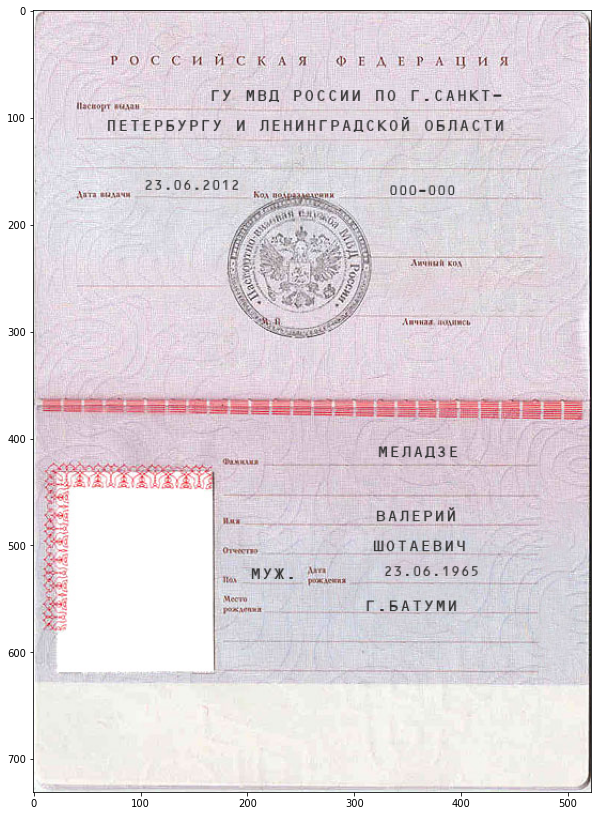

In [ ]:
p1.show()

In [ ]:
p1.fill_photo()

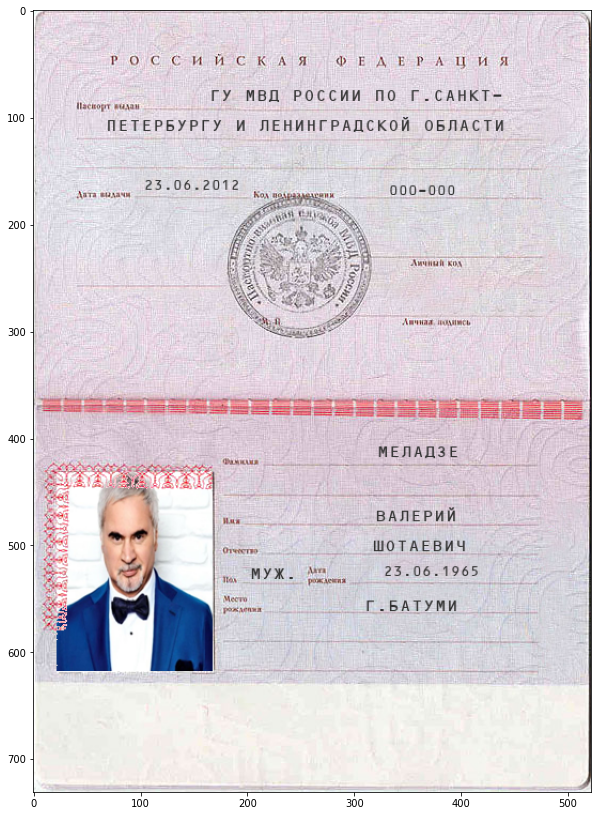

In [ ]:
p1.show()

## Окей, оно работает.  
### Теперь надо найти базу

## 1. Загрузим данные (имена, фамилии, отчества)

In [ ]:
m_names, f_names, surnames, m_s_names, f_s_names = [], [], [], [], []
text_data = {
    "male_names": [], 
    "female_names": [], 
    "surnames": [], 
    "surnames_freqs": [],
    "male_s_names": [], 
    "female_s_names": [],
    "birth_places": []
}

prefix = PREFIX + "text_data/"
postfix = ".txt"
files = [
    "male_names", "female_names", "surnames", "male_s_names", "female_s_names", "birth_places"
]

for file_name in files:
    with open(prefix + file_name + postfix, "r", encoding="utf-8") as file:
        for line in file:
            words = line.strip().split()
            text_data[file_name].append(words[0])
            if file_name == "surnames":
                text_data["surnames_freqs"].append(float(words[1].replace(',', '.')))
text_data["surnames_freqs"] = np.array(text_data["surnames_freqs"]) / np.sum(text_data["surnames_freqs"])

In [ ]:
def change_surname(word, sex='f'):
    if sex == 'm' or len(word) < 5:
        return word.upper()
    if len(word) >= 2 and word[-1] == 'й':
        return word[:-2].upper() + 'АЯ'
    return word.upper() + 'А'


def generate_data(dct, N, f_corners, p_corners, base_image):
    passports = []
    
    Surname = ss.rv_discrete(values=(np.arange(len(dct["surnames"])), dct["surnames_freqs"]))
    Delta = ss.rv_discrete(values=(
        [14, 20, 45] + list(range(15, 20)) + list(range(21, 45)) + list(range(46, 100)),
        [0.3, 0.3, 0.3] + [0.1 / 83 for _ in range(83)]
    ))
    
    surnames_inds = Surname.rvs(size=N)
    deltas = Delta.rvs(size=N)
    m_names = np.random.choice(dct["male_names"], size=(N // 2))
    m_s_names = np.random.choice(dct["male_s_names"], size=(N // 2))
    f_names = np.random.choice(dct["female_names"], size=(N - N // 2))
    f_s_names = np.random.choice(dct["female_s_names"], size=(N - N // 2))
    cities = np.random.choice(dct["birth_places"], size=N)
    Fms = pd.read_csv(PREFIX + "text_data/fms_unit.csv")
    
    years = np.random.choice(np.arange(1992, 2025), size=N)
    months = np.random.choice(np.arange(1, 13), size=N)
    month_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    photos = {'m': os.listdir(PREFIX + "photo_data/men/"), 'f': os.listdir(PREFIX + "photo_data/women/")}

    for i in range(N):
        sex = 'm' if i < N // 2 else 'f'
        day = np.random.choice(
            np.arange(month_days[months[i] - 1]) + 1 +\
            int(months[i] == 2 and (years[i] % 4 == 0 and (years[i] % 100 != 0 or years[i] % 400 == 0))), 
            size=1
        )[0]
        
        city = cities[i]
        if city == "Санкт-Петербург" and years[i] - deltas[i] < 1992:
            city = "ЛЕНИНГРАД"
        else:
            city = np.random.choice(["Г.", "ГОР."], p=[0.7, 0.3]) + city.upper()

        fms = Fms.iloc[np.random.randint(Fms.shape[0])]

        surname = change_surname(dct["surnames"][surnames_inds[i]], sex)
        if np.random.randint(100) == 0:
            surname += '-' + change_surname(dct["surnames"][Surname.rvs(size=1)[0]], sex) 
            
        passports.append(
            Passport(
                f_corners,
                p_corners, 
                base_image, 
                dep=fms["name"],
                code=fms["code"],
                surname=surname, 
                name=m_names[i].upper() if sex == 'm' else f_names[i - N // 2].upper(), 
                s_name=m_s_names[i].upper() if sex == 'm' else f_s_names[i - N // 2].upper(),
                sex="МУЖ." if sex == 'm' else "ЖЕН.",
                p_date=f"{day:0{2}}.{months[i]:0{2}}.{years[i]:0{4}}",
                b_date=f"{day:0{2}}.{months[i]:0{2}}.{years[i] - deltas[i]:0{4}}",
                b_place=city,
                photo = Image.open(PREFIX + "photo_data/" + ('men/' if sex == 'm' else 'women/') + np.random.choice(photos[sex]))
            )
        )
        passports[-1].fill()
        passports[-1].fill_photo()
    return passports

In [ ]:
passports = generate_data(text_data, 1000, f_corners, p_corners, passport)

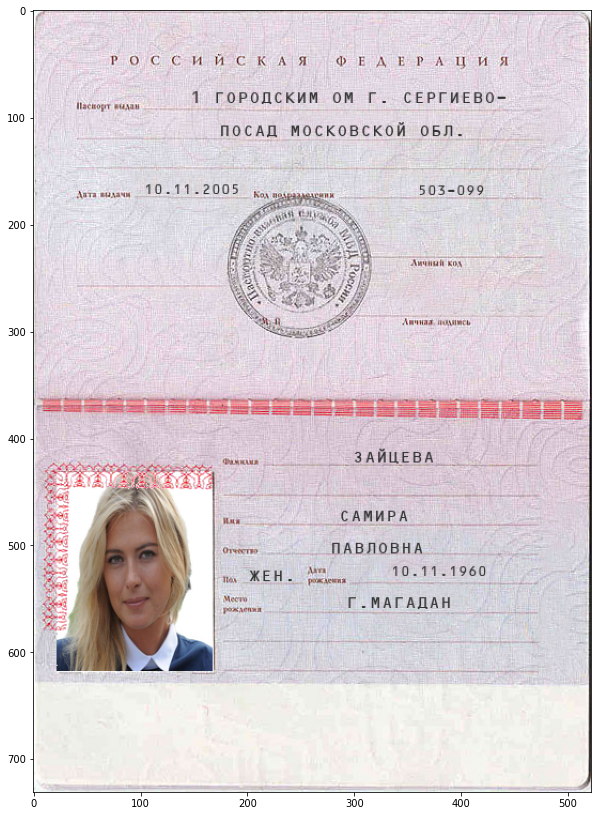

In [ ]:
i = np.random.choice(np.arange(1000))
passports[i].show()

In [ ]:
passports[0].fields

{'dep': <__main__.TextField at 0x7f7febef6400>,
 'p_date': <__main__.TextField at 0x7f7febef6b50>,
 'code': <__main__.TextField at 0x7f7febef64f0>,
 'surname': <__main__.TextField at 0x7f7febef6310>,
 'name': <__main__.TextField at 0x7f7febef6460>,
 's_name': <__main__.TextField at 0x7f7febef6910>,
 'sex': <__main__.TextField at 0x7f7febef6520>,
 'b_date': <__main__.TextField at 0x7f7febef69a0>,
 'b_place': <__main__.TextField at 0x7f7febef69d0>}

In [ ]:
dataset = []
for i, p in enumerate(passports):
    p.img2.save(PREFIX + f"dataset/images/passport{i}.jpg")
    texts, f_names = [], ["dep", "p_date", "code", "surname", "name", "s_name", "sex", "b_date", "b_place"]
    for t in f_names:
        texts.append(p.fields[t].word)
    data = np.hstack([p.f_corners.flatten(), p.p_corners.flatten()])
    dataset.append(np.hstack([[f"passport{i}.jpg"], np.array(p.img2).shape, texts, data]))
dataset[0].shape, passports[0].img2.size

((77,), (522, 731))

In [ ]:
photo_cols = ["up-left-x", "up-left-y", "up-right-x", "up-right-y", "bottom-left-x", "bottom-left-y", "bottom-right-x", "bottom-right-y"]

f_names_2 = ["dep1", "dep2", "dep3", "p_date", "code", "surname1", "surname2", "name", "s_name", "sex", "b_date", "b_place1", "b_place2", "b_place3"]
f_names = ["dep", "p_date", "code", "surname", "name", "s_name", "sex", "b_date", "b_place"]
fields_corners_cols = np.hstack([[f"{t}-left-x", f"{t}-left-y", f"{t}-right-x", f"{t}-right-y"] for t in f_names_2])

cols = np.hstack([["file_name", "H", "W", "channels"], f_names, fields_corners_cols, photo_cols])

In [ ]:
DATA = pd.DataFrame(np.array(dataset), columns=cols)

In [ ]:
DATA.to_csv(PREFIX + "dataset/Passports.csv")

In [ ]:
passports = np.random.shuffle(passports)